# **c-GNF simulated experiments on two-wave model with setting 3**  

**Author**       : Sourabh Balgi  
**Author email** : sourabh.balgi@liu.se  
**Created on**   : 12-June-2023  
**Last modofied on**   : 12-June-2023  



In [1]:
import datetime
now = datetime.datetime.now()
print("Code run on date and time for reproducibility of results and plots : ")
print(now.strftime("%Y-%m-%d %H:%M:%S"))

Code run on date and time for reproducibility of results and plots : 
2023-06-14 11:16:48


In [2]:
# General helper packages
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'#0,1,2,3
import socket
import numpy as np
np.set_printoptions(precision=3, suppress=None)
import datetime
import math
import random
import sys
temp_argv = sys.argv
import timeit
from timeit import default_timer as timer
import lib.utils as utils
from datetime import datetime
import re
import yaml

# packages for data handling and plotting/printing
import pandas as pd
import seaborn as sns
import graphviz
import matplotlib
from matplotlib import cm
# %matplotlib notebook
%matplotlib inline  
from matplotlib import pyplot as plt
from dowhy import CausalModel
import networkx as nx
from PIL import Image
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 100 # https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
plt.rcParams['savefig.dpi'] = 300
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

# Pytorch
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.cuda
import torch.backends.cudnn as cudnn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

# Import dataset handling (preprocessing+saving+loading) module
import UCIdatasets

# Import modules from GNF for the monotonic normalizer/transformer and graphical conditioner
from models.Normalizers import *
from models.Conditionners import *
from models.NormalizingFlowFactories import buildFCNormalizingFlow
from models.NormalizingFlow import *

cond_types = {"DAG": DAGConditioner, "Coupling": CouplingConditioner, "Autoregressive": AutoregressiveConditioner} # types of conditioners
norm_types = {"affine": AffineNormalizer, "monotonic": MonotonicNormalizer} # types of transformers/normalizers


In [3]:
# Load the preprocessed dataset
def load_data(name, seed=None,n_samples=int(400000/0.8)):
    if name == "s1":
        return WODTKE_SIM(case=name,n_samples=n_samples, seed=seed, 
                          theta_11 =0, theta_21 =0,  gamma_12=0,  gamma_21=0)
    
    elif name == "s2":
        return WODTKE_SIM(case=name,n_samples=n_samples, seed=seed, 
                          theta_11 =0.2, theta_21 =0.2,  gamma_12=0.0,  gamma_21=0.4)
    
    elif name == "s3":
        return WODTKE_SIM(case=name,n_samples=n_samples, seed=seed, 
                          theta_11 =0.2, theta_21 =0.2,  gamma_12=0.2,  gamma_21=0.4)
    
    else:
        raise ValueError('Unknown dataset')

from scipy.stats import norm
from torch.distributions.normal import Normal
from torch.distributions.bernoulli import Bernoulli

# Create a dataset object with all the necessary details        
class WODTKE_SIM:

    class Data:

        def __init__(self, data):

            self.x = data.float()
            self.N = self.x.shape[0]

    def __init__(self, case='s1',n_samples=int(2000/0.8), seed=None, ksplit=0, test_size=0.2, theta_11 =0, theta_21 =0,  gamma_12=0,  gamma_21=0):
        # If preprocessed pickle dataset file exists load it, else preprocess the data and save it for future pre-loading
        try:
            import pickle
#             import os
#             os.system(f'mkdir -p UCIdatasets/data/wodtke_sim') # create the folder to save the dataset

            print('UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' + 'pkl')
            with open('UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' + 'pkl',"rb") as f:
                pickle_objects = pickle.load(f)
                
            oldseed = pickle_objects['seed']
            
            if seed != oldseed:
                print(f"Old dataset saved file with seed {oldseed} does not match the new seed {seed}. Creating new dataset with the given seed.")
                raise NotImplementedError # raise an error to force new dataset creation with the new seed
                
            print(f"Old dataset loaded normally from saved file with seed {oldseed}.")
            
            # perform K(5)-fold datasplits for K-fold CV and model robustness check.
            from sklearn.model_selection import KFold
            kf = KFold(n_splits=5, random_state=seed, shuffle=True)

            self.df_ds1 = df_ds1 = pickle_objects['df_ds1']
    
            self.train_index, self.val_index = list(kf.split(df_ds1))[ksplit][0], list(kf.split(df_ds1))[ksplit][1]
        
            df_ds1_train = df_ds1.iloc[self.train_index]
            df_ds1_valtest = df_ds1.iloc[self.val_index]
            df_ds1_val = df_ds1_valtest
            df_ds1_test = df_ds1_valtest

            # calculate mean and std of the dataset for data standardization
            self.trn, self.val, self.tst = df_ds1_train.to_numpy(), df_ds1_val.to_numpy(), df_ds1_test.to_numpy()
            self.df = df_ds1.to_numpy()
            data = np.vstack((self.trn, self.val))
            
            self.mu = mu = data.mean(axis=0)
            self.sig = s = data.std(axis=0)

            # Load train, val, test splits
            self.trn = self.Data(torch.from_numpy(self.trn))
            self.val = self.Data(torch.from_numpy(self.val))
            self.tst = self.Data(torch.from_numpy(self.tst))
            
            # Load entire dataset
            self.df = self.Data(torch.from_numpy(self.df))

            self.ds1_all_columns = pickle_objects['ds1_all_columns'] # list of varaible names that are the dataframe column header
            self.ds1_cat_columns = pickle_objects['ds1_cat_columns'] # list of categorical varaible names that are the dataframe column header
            self.DS1_OrdinalEncoder = pickle_objects['DS1_OrdinalEncoder'] # ordinal encoder to perform encoding and decoding of the categorial variables into numberical variables for the Guassian Dequantization
            self.n_dims = len(self.ds1_all_columns)
            self.cat_dims = pickle_objects['cat_dims'] # Specify categorical dimensions to indicate which variables need Gaussian Dequantization
            self.A = pickle_objects['A'] # Specify the Causal assumptions in terms of the Adjacency matrix of the causal DAG.
        
            self.dataset_filepath = 'UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' # pre-processed dataset location path
            
            # Complete loading the pre-processed and saved dataset 
            return
        
        
        except:
            # Preprocessed dataset pickle file does not exist or error while loading preprocessed dataset pickle file
            print('ERROR loading old dataset. Creating new dataset files !!')

            import os
            os.system(f'mkdir -p UCIdatasets/data/wodtke_sim') # create the folder to save the dataset
            
            with torch.no_grad():
                mu_C1 = torch.zeros(torch.Size([n_samples,1]))
                sig_C1 = 1.0

                c1 = torch.normal(mu_C1,sig_C1)
#                 print(c1.shape)
                

                # p_A1 = norm.cdf(0.4*c1.numpy()+0.6*c1.numpy()**2)
                p_A1 = norm.cdf(0.4*c1.numpy()+2*gamma_12*c1.numpy()**2)
                p_A1 = torch.from_numpy(p_A1).float()

                A1 = Bernoulli(p_A1)
                a1 = A1.sample(sample_shape=torch.Size([1]))  # normally distributed with loc=0 and scale=1
                a1.squeeze_(0).float()
#                 print(a1.shape)


                mu_C2 = 0.4*c1+0.2*a1

                u_C2 = torch.zeros(torch.Size([n_samples,1]))
                sig_C2 = 1.0

                u_c2 = torch.normal(u_C2,sig_C2)
                c2 = mu_C2 + u_c2
#                 print(c2.shape)


                # p_A2 = norm.cdf(0.2*a1.numpy()+0.4*c2.numpy()+0.2*a1.numpy()**2+0.4*c2.numpy()**2+0.1*a1.numpy()*c1.numpy())
                p_A2 = norm.cdf(0.2*a1.numpy()+0.4*c2.numpy()+gamma_12*a1.numpy()**2+2*gamma_12*c2.numpy()+gamma_12*c1.numpy()*a1.numpy()/2)
                p_A2 = torch.from_numpy(p_A2).float()

                A2 = Bernoulli(p_A2)
                a2 = A2.sample(sample_shape=torch.Size([1]))  # normally distributed with loc=0 and scale=1
                a2.squeeze_(0).float()
#                 print(a2.shape)

                # mu_Y = 0.4*c1+(0.2+theta_11*c1)*a1+(0.4+gamma_21*c1)*(c2-0.4*c1-0.2*a1)+(0.2+theta_21*c1+0.1*a1)*a2
                mu_Y = 0.4*c1+(0.2+theta_11*c1)*a1+(0.4+gamma_21*c1)*(c2-0.4*c1-0.2*a1)+(0.2+theta_21*c1+0.1*a1)*a2

                u_Y = torch.zeros(torch.Size([n_samples,1]))
                sig_Y = 1.0

                u_y = torch.normal(u_Y,sig_Y)
                y = mu_Y + u_y
#                 print(y.shape)

            data = torch.cat((c1,c2,a1, a2, y),dim=1).float()


            import pandas as pd

            # Creating an empty Dataframe with column names only
            df_ds1 = pd.DataFrame(data.cpu().numpy(),
                                  columns=['C1', 'C2', 'A1', 'A2', 'Y'])

            reorder_vars = ['C1', 'C2', 'A1', 'A2', 'Y']
            df_ds1 = df_ds1[reorder_vars]

            self.df_ds1 = df_ds1

            all_ds1_columns = list(df_ds1) # list of varaible names that are the dataframe column header
            ds1_variables_len = len(all_ds1_columns) # dimension of the dataset

            df_ds1

            import matplotlib.pyplot as plt

            df_ds1_copy = df_ds1.copy()
            df_ds1_copy = df_ds1_copy.set_axis([r'$C_1$', r'$C_2$', r'$A_1$', r'$A_2$', r'$Y$'], axis=1, inplace=False)
            reorder_vars_ltx = [r'$C_1$', r'$C_2$', r'$A_1$', r'$A_2$', r'$Y$']#, r'$Z_Y$'
            df_ds1_copy = df_ds1_copy[reorder_vars_ltx]

#             g = sns.pairplot(df_ds1_copy, diag_kind="kde")#diag_kind="hist")#, diag_kind="kde"
#     #             g = sns.pairplot(df_ds1_obs_int, hue='do(A)', diag_kind="hist")#, diag_kind="kde"
#             g.fig.suptitle(f'Observational densities from the data generating process or the structural equations', y=1.002)
#             plt.tight_layout()

#             out_filename = 'UCIdatasets/data/' + f'wodtke_sim/{case}_{seed:05d}_distribution_plot.png'
#             g.savefig(f'{out_filename}', dpi=100, bbox_inches="tight")
#     #             sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .45), title='Model')
#             plt.show()

#             import os
#             os.system(f'mogrify -trim {out_filename}')

            path= 'UCIdatasets/data/' +  f'wodtke_sim/'
            dot_filename = path + f'DAG.dot' # Dot-filename specifying the causal DAG from dagitty 
            # !cp ./UCIdatasets/data/toy/toy_ssv.dot ./UCIdatasets/data/toy/toy.dot
            # !cp ./UCIdatasets/data/toy/toy_ssv.dot ./UCIdatasets/data/toy/toy.dot

            # Create a causal model to visualize the DAG and obtain the adjaceny matrix for the Graphical conditioner
            cl_model=CausalModel(
                    data = df_ds1,
                    treatment=['A1', 'A2'],
                    outcome=['Y'],
                    graph=dot_filename,
                    )

            out_filename = path + f'DAG.png'
            try:
                # os.system(f'mkdir -p {'UCIdatasets/data/'}toy') # create the folder to save the dataset

                import pygraphviz as pgv
                agraph = nx.drawing.nx_agraph.to_agraph(cl_model._graph._graph)
                agraph.draw(out_filename, format="png", prog="dot")
            except:
                cl_model._graph.logger.warning("Warning: Pygraphviz cannot be loaded. Check that graphviz and pygraphviz are installed.")
                cl_model._graph.print("Using Matplotlib for plotting")
                import matplotlib.pyplot as plt

                solid_edges = [(n1,n2) for n1,n2, e in cl_model._graph._graph.edges(data=True) if 'style' not in e ]
                dashed_edges =[(n1,n2) for n1,n2, e in cl_model._graph._graph.edges(data=True) if ('style' in e and e['style']=="dashed") ]
                plt.clf()

                pos = nx.layout.shell_layout(cl_model._graph._graph)
                nx.draw_networkx_nodes(cl_model._graph._graph, pos, node_color='yellow',node_size=400 )
                nx.draw_networkx_edges(
                        cl_model._graph._graph,
                        pos,
                        edgelist=solid_edges,
                        arrowstyle="-|>",
                        arrowsize=12)
                nx.draw_networkx_edges(
                        cl_model._graph._graph,
                        pos,
                        edgelist=dashed_edges,
                        arrowstyle="-|>",
                        style="dashed",
                        arrowsize=12)

                labels = nx.draw_networkx_labels(cl_model._graph._graph, pos)

                plt.axis('off')
                plt.savefig(out_filename)
                plt.draw()
            os.system('mogrify -trim ' + out_filename)

            from IPython.display import display
            from PIL import Image

            dag_path = out_filename
            display(Image.open(dag_path))

            ds1_cDAG = cl_model._graph._graph

            # https://networkx.org/documentation/stable/reference/convert.html
            df_ds1_cDAG = nx.to_pandas_adjacency(ds1_cDAG, dtype=int) # row (parent) -> column (child)
            df_ds1_cDAG = df_ds1_cDAG.reindex(reorder_vars)
            df_ds1_cDAG = df_ds1_cDAG[reorder_vars]


            # Saving the adjacency matrix of the causal model for the Graphical conditioner
            # Adjacency matrix format is row (parent) -> column (child), i.e., row indicates parent node and the column indicates the child node.
            df_filename_Amat = 'UCIdatasets/data/' +  f'wodtke_sim/DAG_Amat.csv'
            df_ds1_cDAG.to_csv(df_filename_Amat)#, 


            all_ds1_columns = list(df_ds1) # get the list of all the variable names in the dataset
            cat_col_names = ['A1', 'A2'] # Specify the list of categorical varaibles that are in the dataset for Gaussian dequantization
            
            # loop to change each column to category type to get the dimension/position of the categorical variable in the dataframe and respective unique categories.
            dict_unique_cats = {}
            dict_cat_dims = {}
            for i, col in enumerate(all_ds1_columns):
                if col in cat_col_names:
                    df_ds1[col] = df_ds1[col].astype('category',copy=False)
                    dict_unique_cats[col] = list(df_ds1[col].unique())
                    print(f'\n{i}. {col}: {len(dict_unique_cats[col])} - {dict_unique_cats[col]}')    
                    # dict_cat_dims[i] = len(dict_unique_cats[col])
                    dict_cat_dims[i] = int(max(dict_unique_cats[col])+1)


            # perform the encoding of ordinal/categorical variables into numerical variable for Gaussian dequantization
            from sklearn.preprocessing import OrdinalEncoder
            DS1_OrdinalEncoder = OrdinalEncoder()
            DS1_OrdinalEncoder.fit(df_ds1[cat_col_names])
            print(f'\n{DS1_OrdinalEncoder.categories_}') # Display the respective categorical to numerical encoding dictionary

            # # Categorical to Numerical encoding
            # df_ds1[cat_col_names] = DS1_OrdinalEncoder.transform(df_ds1[cat_col_names])
            # df_ds1[cat_col_names].head()
            
            ## Numerical to Categorical decoding
            # df_ds1[cat_col_names] = DS1_OrdinalEncoder.inverse_transform(df_ds1[cat_col_names])
            # df_ds1[cat_col_names].head()

            ## Categorical to Numerical encoding
            # df_ds1[cat_col_names] = DS1_OrdinalEncoder.transform(df_ds1[cat_col_names])
            # df_ds1[cat_col_names].head()
            
            # Perform random train, validation and test splits for CV and model robustness chec by multiple random seeded training
            from sklearn.model_selection import train_test_split
            df_ds1_train, df_ds1_valtest = train_test_split(df_ds1, random_state=seed, test_size=test_size)#, stratify=df_ds1[['R_disc', 'A']])#, stratify=df_ds1[['F_disc', 'R_disc', 'S_disc']])#, stratify=df_ds1.U.to_list()             
            df_ds1_val, df_ds1_test = train_test_split(df_ds1_valtest, random_state=seed, test_size=0.5)#, stratify=df_ds1_valtest[['R_disc', 'A']])#, stratify=df_ds1_valtest[['F_disc', 'R_disc', 'S_disc']])#, stratify=df_ds1_valtest.U.to_list(),

            # Create dictionary to save the necessary preprocessed variables into pickle file for future pre-loading
            pickle_objects = {}
            pickle_objects['df_ds1'] = df_ds1
            pickle_objects['df_ds1_train'] = df_ds1_train
            pickle_objects['df_ds1_valtest'] = df_ds1_valtest
            pickle_objects['df_ds1_val'] = df_ds1_valtest
            pickle_objects['df_ds1_test'] = df_ds1_valtest
            
            pickle_objects['ds1_all_columns'] = all_ds1_columns
            pickle_objects['ds1_cat_columns'] = cat_col_names
            pickle_objects['DS1_OrdinalEncoder'] = DS1_OrdinalEncoder
            pickle_objects['cat_dims'] = dict_cat_dims
            pickle_objects['seed'] = seed
            
            ## Get the adjacency matrix
            A = df_ds1_cDAG.to_numpy().transpose() # column (parent) -> row (child)
            pickle_objects['A'] = torch.from_numpy(A).float() # column (parent) -> row (child)
    
            print(f'Variables = {reorder_vars} of adjacency matrix with column (parent) -> row (child)\n')
            print(pickle_objects['A'])
            import pickle
            with open('UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' + 'pkl',"wb") as f:
                pickle.dump(pickle_objects, f)
                
            print('UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' + 'pkl')

        df_ds1_val = df_ds1_valtest
        df_ds1_test = df_ds1_valtest

        # calculate mean and std of the dataset for data standardization
        self.trn, self.val, self.tst = df_ds1_train.to_numpy(), df_ds1_val.to_numpy(), df_ds1_test.to_numpy()
        self.df = df_ds1.to_numpy()
        data = np.vstack((self.trn, self.val))

        self.mu = mu = data.mean(axis=0)
        self.sig = s = data.std(axis=0)

        # Load train, val, test splits
        self.trn = self.Data(torch.from_numpy(self.trn))
        self.val = self.Data(torch.from_numpy(self.val))
        self.tst = self.Data(torch.from_numpy(self.tst))

        # Load entire dataset
        self.df = self.Data(torch.from_numpy(self.df))

        self.df_ds1 = pickle_objects['df_ds1']
        self.df_ds1_train = pickle_objects['df_ds1_train']
        self.df_ds1_val = pickle_objects['df_ds1_val']
        self.df_ds1_test = pickle_objects['df_ds1_test']

        self.ds1_all_columns = pickle_objects['ds1_all_columns'] # list of varaible names that are the dataframe column header
        self.ds1_cat_columns = pickle_objects['ds1_cat_columns'] # list of categorical varaible names that are the dataframe column header
        self.DS1_OrdinalEncoder = pickle_objects['DS1_OrdinalEncoder'] # ordinal encoder to perform encoding and decoding of the categorial variables into numberical variables for the Guassian Dequantization
        self.n_dims = len(self.ds1_all_columns)
        self.cat_dims = pickle_objects['cat_dims'] # Specify categorical dimensions to indicate which variables need Gaussian Dequantization
        self.A = pickle_objects['A'] # Specify the Causal assumptions in terms of the Adjacency matrix of the causal DAG.
        Z_Sigma = np.eye(data.shape[1])
#         Z_Sigma[0, 3] = rho
#         Z_Sigma[3, 0] = rho
        self.Z_Sigma = torch.from_numpy(Z_Sigma).float()


        self.dataset_filepath = 'UCIdatasets/data/' + f'wodtke_sim/{case}_{n_samples}_{seed:05d}.' # pre-processed dataset location path

        # Complete loading the pre-processed and saved dataset 
        return

# dataset="s3"
# data = load_data(dataset, seed=6)
# # data = load_data(dataset, seed=31415)
    

# cGNF training function wrapper with some important arguments

In [4]:
# cGNF training function wrapper with some important arguments
def train(dataset="s1", load=True, nb_step_dual=100, nb_steps=20, path="", l1=.1, nb_epoch=10000,
          int_net=[200, 200, 200], emb_net=[200, 200, 200], b_size=1024, all_args=None, file_number=None, train=True,
          solver="CC", nb_flow=1, weight_decay=1e-5, learning_rate=1e-3, cond_type='DAG', norm_type='affine', n_mce_samples=20000, mce_b_size=20000, nb_estop=50,seed=None):
    print(str(all_args))

    # set cuda device for pytorch if available
    device = "cpu" if not(torch.cuda.is_available()) else "cuda:0"
    
    # Set manual seed for reproduction of experiments
    if seed is None:
        seed = random.randint(1, 20000)
    print(f"Running simulation with seed {seed}")

    random.seed(seed)
    np.random.seed(seed=seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    else:
        print("GPU device not available!")

    # Load dataset for training and inference
    print("Loading data...")
    data = load_data(dataset, seed=seed)
    data_mu = torch.from_numpy(data.mu).float().to(device)
    data_sigma = torch.from_numpy(data.sig).float().to(device)
    print(f"data_mu = \n{data_mu.cpu().numpy()}, \ndata_sigma = \n{data_sigma.cpu().numpy()}")

#     df_filename = data.dataset_filepath+ 'csv.gz'
    df = data.df_ds1#pd.read_csv(df_filename, compression='gzip')
    
#     print(f'Dataset saved from {df_filename} to {path}/{dataset}.csv.gz')
    print(list(df.columns))
    print("Data loaded.")
    
    d_trn = TensorDataset(data.trn.x.float())
    d_val = TensorDataset(data.val.x.float())
    d_tst = TensorDataset(data.tst.x.float())
    
    workers = 6
    pin_memory = True
    batch_size = b_size#128*8#128#2000#12/5#256#
    
    # Create pytorch dataloaders for the respective datasets to process the data in batches
    print(f"Batch size = trn:{batch_size:7d},  val:{len(d_val)//4:7d},  tst:{len(d_tst)//4:7d}")
    l_trn = DataLoader(d_trn, 
                       batch_size=batch_size,
                             num_workers=int(workers),
                             shuffle=True,#
                             pin_memory=pin_memory,
                             drop_last=False) # create train dataloader
    l_val = DataLoader(d_val, 
                       batch_size=len(d_val)//4,
                             num_workers=int(workers),
                             shuffle=True,#False,
                             pin_memory=pin_memory,
                             drop_last=False) # create validation dataloader
    l_tst = DataLoader(d_tst, 
                       batch_size=len(d_tst)//4,
                             num_workers=int(workers),
                             shuffle=True,#False,
                             pin_memory=pin_memory,
                             drop_last=False) # create test dataloader

    print(f"Number of samples = trn:{len(d_trn):7d},  val:{len(d_val):7d},  tst:{len(d_tst):7d}")
    print(f"Number of batches = trn:{len(l_trn):7d},  val:{len(l_val):7d},  tst:{len(l_tst):7d}")
    epoch_iters = len(l_trn)
    
    print(f"Dataset_mean = {data.mu}")
    print(f"Dataset_sigma = {data.sig}")
    
    dim = data.trn.x.shape[1]
    conditioner_type = cond_types[cond_type]
    conditioner_args = {"in_size": dim, "hidden": emb_net[:-1], "out_size": emb_net[-1]}
    if conditioner_type is DAGConditioner:
        conditioner_args['l1'] = l1
        conditioner_args['gumble_T'] = .5
        conditioner_args['nb_epoch_update'] = nb_step_dual
        conditioner_args["hot_encoding"] = False#True
        conditioner_args['A_prior'] = data.A.to(device)
        
    print(f'{conditioner_args}')

    normalizer_type = norm_types[norm_type]
    if normalizer_type is MonotonicNormalizer:
        normalizer_args = {"integrand_net": int_net, "cond_size": emb_net[-1], "nb_steps": nb_steps,
                           "solver": solver, 
                           "mu": data_mu, "sigma": data_sigma, # standardize the input data, comment to learn cGNF on unstandardized data
                            # "cat_dims": None
                           "cat_dims": data.cat_dims# categorical dimensions for Gaussian dequantization
                          }
    else:
        normalizer_args = {}
    print(f'{normalizer_args}')

    if file_number is None:
        file_number = 0
    
    # Creating the cGNF model
    model = buildFCNormalizingFlow(nb_flow, conditioner_type, conditioner_args, normalizer_type, normalizer_args)
    print(f'{model.getConditioners()[0]}')
    print(f'{model.getNormalizers()[0]}')
    _best_valid_loss = np.inf # Loss initialization

    ## Pytorch Loss function optimizer initialization
    # opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.999))
    opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

#     n_iters_val = (epoch_iters//4)+1 #50 # check validation loss after 50 iterations
#     n_ckpt_cycle = (epoch_iters//4)+1 #50 # check validation loss after 50 iterations
    n_iters_val = (epoch_iters//1) #50 # check validation loss after 50 iterations
    n_ckpt_cycle = (epoch_iters//1) #50 # check validation loss after 50 iterations
    n_ckpt_cycle_10 = n_ckpt_cycle*10

    x_val_diff_norm_best = np.inf
    x_tst_diff_norm_best = np.inf
    x_val_do_diff_norm_best = np.inf
    x_tst_do_diff_norm_best = np.inf

    model.to(device) # move model to GPU
    nb_iters = nb_epoch*epoch_iters
    
    # 
    # mce_b_size = 2000
    # n_mce_samples = 2000#00

    with torch.no_grad():
        n_mce_samples = n_mce_samples#2000
        Z_do = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
        z_do = Z_do.sample(torch.Size([n_mce_samples]))#.to(device)

        l_do_cat_dims = list(data.cat_dims.keys())
        l_do_n_cats = list(data.cat_dims.values())

        if len(l_do_cat_dims) > 1:
            all_a = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats])#.to(device)
        else:
            all_a = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats]).unsqueeze(-1)#.to(device)

        z_do_n = z_do.unsqueeze(1).expand(-1, all_a.shape[0], -1).clone()#.to(device)
        all_a_n=all_a.unsqueeze(0).expand(n_mce_samples,-1,-1)#.to(device)

        z_do_n[:,:,l_do_cat_dims] = all_a_n
        z_do_n = z_do_n.transpose_(1,0).reshape(-1,dim).to(device)#.view(-1,n_samples,dim)


    # create dataloader-iterator for continuous dataloading
    l_trn_iter = iter(l_trn) 

    n_estop = 0
    n_iters = 0
    
    # Start the epcoh training
    for epoch in range(file_number+1, file_number+1+nb_epoch):
                
        ll_tot = 0
        start = timer()

        # Update constraints
        if conditioner_type is DAGConditioner:
            with torch.no_grad():
                for conditioner in model.getConditioners():
                    conditioner.constrainA(zero_threshold=0.)

        # Training loop
        if train:
            model.train()
            if n_estop > nb_estop:
                break
            for it, cur_x in enumerate(l_trn):
                n_iters += 1
                cur_x=cur_x[0].to(device)
                if normalizer_type is MonotonicNormalizer:
                    for normalizer in model.getNormalizers():
                        normalizer.nb_steps = nb_steps + torch.randint(0, 10, [1])[0].item()
                z, jac = model(cur_x)
                
                loss = model.loss(z, jac)
                if math.isnan(loss.item()) or math.isinf(loss.abs().item()):
                    torch.save(model, path + '/NANmodel.pt')
                    print("Error NAN in loss")
                    exit()
                ll_tot += loss.detach()
                opt.zero_grad()
                loss.backward(retain_graph=True)
                opt.step()
                
                # Calculate validation loss at specified intervals of the training
                if n_iters % n_iters_val==0:
                    n_estop += n_iters_val/epoch_iters
                    # Valid loop
                    model.eval()
                    ll_val = 0.
                    with torch.no_grad():
                        if normalizer_type is MonotonicNormalizer:
                            for normalizer in model.getNormalizers():
                                normalizer.nb_steps = nb_steps + 20
                        for iv, cur_x in enumerate(l_val):
                            cur_x=cur_x[0].to(device)
                            z, jac = model(cur_x)
                            ll = (model.z_log_density(z) + jac)
                            ll_val += ll.mean().item()
                        ll_val /= iv + 1

                        end = timer()
                        dagness = 0
                        print("epoch: {:d} - Train loss: {:4f} - Valid log-likelihood: {:4f} - <<DAGness>>: {:4f} - Elapsed time per epoch {:4f} (seconds)".
                                    format(epoch, ll_tot.item()/(it+1), ll_val, dagness, end-start))

                        if dagness < 1e-20 and -ll_val < _best_valid_loss:
                            n_estop = 0
                            _best_valid_loss = -ll_val
                            print("------- New best validation loss --------")
                            print("++ epoch: {:d} - Train loss: {:4f} - Valid log-likelihood: {:4f} - <<DAGness>>: {:4f} - Elapsed time per epoch {:4f} (seconds)".
                                    format(epoch, ll_tot.item(), ll_val, dagness, end-start))
                            torch.save(model, path + '/_best_model.pt') # save the current best validation model.
                            torch.save(opt.state_dict(), path + '/_best_optimizer.pt') # save the current best validation optimizer state.
                            
                            cur_x_do_inv = model.invert(z_do_n, do_idx=l_do_cat_dims, do_val=torch.narrow(z_do_n,1,min(l_do_cat_dims),len(l_do_cat_dims)))
                            cur_x_do_U_inv = cur_x_do_inv.view(-1,n_mce_samples,dim)
                            cur_x_do_U_n_inv_mean=cur_x_do_U_inv.mean(1).cpu()#.numpy()
                            print(f'# ++ Average Counterfactual Outcome = \n{cur_x_do_U_n_inv_mean}')
                            
#                             print('Lambda_10 = '+f'{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]}')
#                             print('Lambda_01 = '+f'{cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]}')
#                             print('Lambda_11 = '+f'{cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]}')
                            
                            print('Lambdas [10, 01, 11] = '+ f'[{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]:0.3f}]')
        
                            # Open a file with access mode 'a'
                            with open(path + "/_cGNF_ATE_lambda.txt", "a") as file_object:
                                file_object.write(f'# {len(d_trn)} ++ cGNF - lambda_[10, 01, 11] =  ,  '+ f'[{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]:0.3f}]\n')

                    torch.save(model, path + '/model.pt') # save the current model at validation intervals.
                    torch.save(opt.state_dict(), path + '/ADAM.pt')

            torch.save(model, path + '/model.pt') # save the current model before termination.
            torch.save(opt.state_dict(), path + '/ADAM.pt')
            
            model.train() # switch back from eval to train mode
            ll_tot /= it + 1
            model.step(epoch, ll_tot) # store/update model training loss
        else:
            ll_tot = 0.
            
    print(f'\n\nModel and logs saved in {path} folder.\n\n')

    return model, data # return the trained cGNF model and the dataset object for further inference



# cGNF argument specification and training initialization below

['/home/souba35/anaconda3/envs/rtorchp1/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/souba35/.local/share/jupyter/runtime/kernel-8e71d7c8-b765-4031-8a4b-6fc9a1429d2c.json']
Namespace(b_size=1024, conditioner='DAG', dataset='s3', emb_net=[40, 30, 20], f_number=None, folder='', gumble_T=0.5, int_net=[15, 10, 5], l1=0.5, learning_rate=0.0003, load=False, load_config=None, mce_b_size=2000, n_mce_samples=2000, nb_epoch=50000, nb_estop=50, nb_flow=1, nb_steps=50, nb_steps_dual=50, normalizer='monotonic', seed=31415, solver='CC', test=False, weight_decay=1e-05)
Running simulation with seed 31415
Loading data...
UCIdatasets/data/wodtke_sim/s3_500000_31415.pkl
ERROR loading old dataset. Creating new dataset files !!


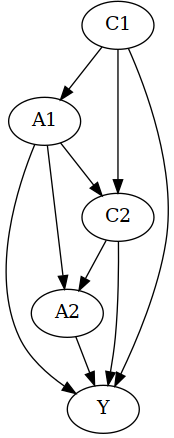


2. A1: 2 - [1.0, 0.0]

3. A2: 2 - [1.0, 0.0]

[array([0., 1.]), array([0., 1.])]
Variables = ['C1', 'C2', 'A1', 'A2', 'Y'] of adjacency matrix with column (parent) -> row (child)

tensor([[0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.]])
UCIdatasets/data/wodtke_sim/s3_500000_31415.pkl
data_mu = 
[4.235e-05 1.221e-01 6.158e-01 5.994e-01 3.279e-01], 
data_sigma = 
[1.    1.089 0.486 0.49  1.406]
['C1', 'C2', 'A1', 'A2', 'Y']
Data loaded.
Batch size = trn:   1024,  val:  25000,  tst:  25000
Number of samples = trn: 400000,  val: 100000,  tst: 100000
Number of batches = trn:    391,  val:      4,  tst:      4
Dataset_mean = [4.235e-05 1.221e-01 6.158e-01 5.994e-01 3.279e-01]
Dataset_sigma = [1.    1.089 0.486 0.49  1.406]
{'in_size': 5, 'hidden': [40, 30], 'out_size': 20, 'l1': 0.5, 'gumble_T': 0.5, 'nb_epoch_update': 50, 'hot_encoding': False, 'A_prior': tensor([[0., 0., 0., 0., 0.],
        [1.,

epoch: 11 - Train loss: 4.853087 - Valid log-likelihood: -3.732303 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.126692 (seconds)
epoch: 12 - Train loss: 4.848764 - Valid log-likelihood: -3.747739 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.142783 (seconds)
epoch: 13 - Train loss: 4.843049 - Valid log-likelihood: -3.715988 - <<DAGness>>: 0.000000 - Elapsed time per epoch 44.974127 (seconds)
------- New best validation loss --------
++ epoch: 13 - Train loss: 1893.632202 - Valid log-likelihood: -3.715988 - <<DAGness>>: 0.000000 - Elapsed time per epoch 44.974127 (seconds)
# ++ Average Counterfactual Outcome = 
tensor([[0.0264, 0.0189, 0.0000, 0.0000, 0.0469],
        [0.0264, 0.0189, 0.0000, 1.0000, 0.2606],
        [0.0264, 0.2113, 1.0000, 0.0000, 0.2302],
        [0.0264, 0.2113, 1.0000, 1.0000, 0.5030]])
Lambdas [10, 01, 11] = [0.183, 0.214, 0.273]
epoch: 14 - Train loss: 4.837413 - Valid log-likelihood: -3.694653 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.3923

/home/souba35/prj/cGNF_blau_duncan/models/Conditionners/DAGConditioner.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha = torch.tensor(self.getAlpha())


epoch: 51 - Train loss: 4.623517 - Valid log-likelihood: -3.677138 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.932175 (seconds)
epoch: 52 - Train loss: 4.623208 - Valid log-likelihood: -3.665191 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.872589 (seconds)
epoch: 53 - Train loss: 4.623659 - Valid log-likelihood: -3.664554 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.544165 (seconds)
epoch: 54 - Train loss: 4.620658 - Valid log-likelihood: -3.666642 - <<DAGness>>: 0.000000 - Elapsed time per epoch 46.200107 (seconds)
epoch: 55 - Train loss: 4.624071 - Valid log-likelihood: -3.687812 - <<DAGness>>: 0.000000 - Elapsed time per epoch 46.541650 (seconds)
epoch: 56 - Train loss: 4.621337 - Valid log-likelihood: -3.638495 - <<DAGness>>: 0.000000 - Elapsed time per epoch 44.932374 (seconds)
epoch: 57 - Train loss: 4.626127 - Valid log-likelihood: -3.668597 - <<DAGness>>: 0.000000 - Elapsed time per epoch 45.397858 (seconds)
epoch: 58 - Train loss: 4.622497 - Valid log-lik

epoch: 104 - Train loss: 4.617145 - Valid log-likelihood: -3.644306 - <<DAGness>>: 0.000000 - Elapsed time per epoch 41.547070 (seconds)
epoch: 105 - Train loss: 4.618690 - Valid log-likelihood: -3.682198 - <<DAGness>>: 0.000000 - Elapsed time per epoch 41.707767 (seconds)
epoch: 106 - Train loss: 4.617130 - Valid log-likelihood: -3.650224 - <<DAGness>>: 0.000000 - Elapsed time per epoch 42.481371 (seconds)
epoch: 107 - Train loss: 4.619333 - Valid log-likelihood: -3.648340 - <<DAGness>>: 0.000000 - Elapsed time per epoch 43.097458 (seconds)
epoch: 108 - Train loss: 4.615684 - Valid log-likelihood: -3.671904 - <<DAGness>>: 0.000000 - Elapsed time per epoch 43.894260 (seconds)
epoch: 109 - Train loss: 4.617689 - Valid log-likelihood: -3.633420 - <<DAGness>>: 0.000000 - Elapsed time per epoch 42.881009 (seconds)
epoch: 110 - Train loss: 4.616014 - Valid log-likelihood: -3.659954 - <<DAGness>>: 0.000000 - Elapsed time per epoch 41.618513 (seconds)
epoch: 111 - Train loss: 4.620113 - Valid

epoch: 157 - Train loss: 4.616377 - Valid log-likelihood: -3.643904 - <<DAGness>>: 0.000000 - Elapsed time per epoch 37.975765 (seconds)
epoch: 158 - Train loss: 4.616853 - Valid log-likelihood: -3.652591 - <<DAGness>>: 0.000000 - Elapsed time per epoch 37.781688 (seconds)
epoch: 159 - Train loss: 4.614874 - Valid log-likelihood: -3.671283 - <<DAGness>>: 0.000000 - Elapsed time per epoch 38.162377 (seconds)
epoch: 160 - Train loss: 4.612066 - Valid log-likelihood: -3.651277 - <<DAGness>>: 0.000000 - Elapsed time per epoch 38.031884 (seconds)
epoch: 161 - Train loss: 4.613893 - Valid log-likelihood: -3.647832 - <<DAGness>>: 0.000000 - Elapsed time per epoch 38.006303 (seconds)
epoch: 162 - Train loss: 4.614538 - Valid log-likelihood: -3.639903 - <<DAGness>>: 0.000000 - Elapsed time per epoch 38.311437 (seconds)
epoch: 163 - Train loss: 4.612886 - Valid log-likelihood: -3.652674 - <<DAGness>>: 0.000000 - Elapsed time per epoch 37.622935 (seconds)
epoch: 164 - Train loss: 4.614329 - Valid

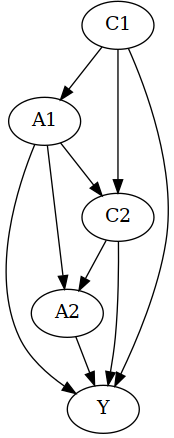

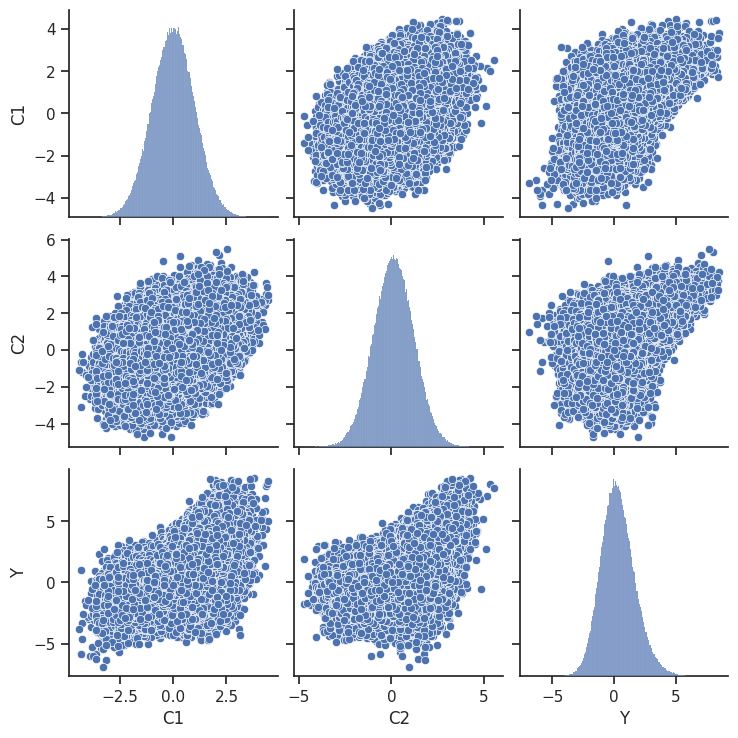

In [4]:
import argparse
datasets = ["s1", "s2", "s3", "new_dataset"]

# Define argument parser with default values
parser = argparse.ArgumentParser(description='')
parser.add_argument("-load_config", default=None, type=str)

# General Parameters
parser.add_argument("-dataset", default='s3', choices=datasets, help="Which toy problem ?")
parser.add_argument("-load", default=False, action="store_true", help="Load a model ?")
parser.add_argument("-folder", default="", help="Folder")
parser.add_argument("-f_number", default=None, type=int, help="Number of heating steps.")
parser.add_argument("-test", default=False, action="store_true") # no model training. Set only testing by loading mdel and the dataset.
parser.add_argument("-nb_flow", type=int, default=1, help="Number of steps in the flow.")

# Optim Parameters
parser.add_argument("-weight_decay", default=1e-5, type=float, help="Weight decay value")
parser.add_argument("-learning_rate", default=3e-4, type=float, help="Weight decay value")
parser.add_argument("-nb_epoch", default=50000, type=int, help="Number of epochs")
parser.add_argument("-b_size", default=1024, type=int, help="Batch size")
# parser.add_argument("-b_size", default=128, type=int, help="Batch size")
parser.add_argument("-seed", default=31415, type=int, help="seed")

# Conditioner Parameters
parser.add_argument("-conditioner", default='DAG', choices=['DAG', 'Coupling', 'Autoregressive'], type=str)
parser.add_argument("-emb_net", default=[40, 30, 20], nargs="+", type=int, help="NN layers of embedding")
parser.add_argument("-nb_steps_dual", default=50, type=int, help="number of step between updating Acyclicity constraint and sparsity constraint")
parser.add_argument("-l1", default=0.5, type=float, help="Maximum weight for l1 regularization")
parser.add_argument("-gumble_T", default=0.5, type=float, help="Temperature of the gumble distribution.")

# Normalizer Parameters
parser.add_argument("-normalizer", default='monotonic', choices=['affine', 'monotonic'], type=str)
parser.add_argument("-int_net", default=[15, 10, 5], nargs="+", type=int, help="NN hidden layers of UMNN")
parser.add_argument("-nb_steps", default=50, type=int, help="Number of integration steps.")
parser.add_argument("-nb_estop", default=50, type=int, help="Number of epochs for early stopping.")
parser.add_argument("-n_mce_samples", default=2000, type=int, help="Number of Monte-Carlo mean estimation samples.")
parser.add_argument("-mce_b_size", default=2000, type=int, help="Monte-Carlo mean estimation Batch size")
parser.add_argument("-solver", default="CC", type=str, help="Which integral solver to use.",
                    choices=["CC", "CCParallel"])

# Print all the training parameters beings used for the current simulation
try:
    sys.argv = ['']
    args = parser.parse_args()
finally:
    sys.argv = temp_argv
print(sys.argv)
    
    
# create a folder to save all the logs/models for the current simulation
now = datetime.now()
dir_name = args.dataset if args.load_config is None else args.load_config
path = "Wodtke_sim_exp_logs/" + dir_name + "/" + now.strftime("%Y_%m_%d_%H_%M_%S") + '_' + socket.gethostname() if args.folder == "" else args.folder

if not(os.path.isdir(path)):
    os.makedirs(path)
    
# Start training the model by calling the training function from above    
model, data = train(args.dataset, load=args.load, path=path, nb_step_dual=args.nb_steps_dual, l1=args.l1, nb_epoch=args.nb_epoch, nb_estop=args.nb_estop,
      int_net=args.int_net, emb_net=args.emb_net, b_size=args.b_size, all_args=args,
      nb_steps=args.nb_steps, file_number=args.f_number,  solver=args.solver, nb_flow=args.nb_flow,
      train=not args.test, weight_decay=args.weight_decay, learning_rate=args.learning_rate,
      cond_type=args.conditioner,  norm_type=args.normalizer,  n_mce_samples=args.n_mce_samples, mce_b_size=args.mce_b_size, seed=args.seed)

x_max,_ = torch.max(data.trn.x, dim=0)
x_min,_ = torch.min(data.trn.x, dim=0)

print(data.trn.x[:2,:])
print(data.trn.x.mean(0))
print(data.trn.x.std(0))
print(data.mu)
print(data.sig)
print(f'X_min = {x_min.numpy()}')
print(f'X_max = {x_max.numpy()}')
print(f'X_mu = {data.mu}')
print(f'X_sigma = {data.sig}')


from IPython.display import display
from PIL import Image

dag_path = './UCIdatasets/data/wodtke_sim/DAG.png'
display(Image.open(dag_path))

df_ds1 = data.df_ds1

df_ds1.describe()

df_ds1.head()

df_ds1.describe()

sns.pairplot(df_ds1)

# Load desired model for evaluation and counterfactual predictions below

In [5]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ''#0,1,2,3
# device = "cpu"

device = "cpu" if not(torch.cuda.is_available()) else "cuda:0"

path = './Wodtke_sim_exp_logs/s3/2023_06_13_14_23_05_lnx00221.ad.liu.se'# specify the location to the saved model
print(path)
model=torch.load(path + '/_best_model.pt', map_location=device)
model = model.to(device)

def batch_iter(X, batch_size, shuffle=False):
    """
    X: feature tensor (shape: num_instances x num_features)
    """
    if shuffle:
        idxs = torch.randperm(X.shape[0])
    else:
        idxs = torch.arange(X.shape[0])
    if X.is_cuda:
        idxs = idxs.cuda()
    for batch_idxs in idxs.split(batch_size):
        yield X[batch_idxs]


./Wodtke_sim_exp_logs/s3/2023_06_13_14_23_05_lnx00221.ad.liu.se


UCIdatasets/data/wodtke_sim/s3_500000_31415.pkl
Old dataset loaded normally from saved file with seed 31415.


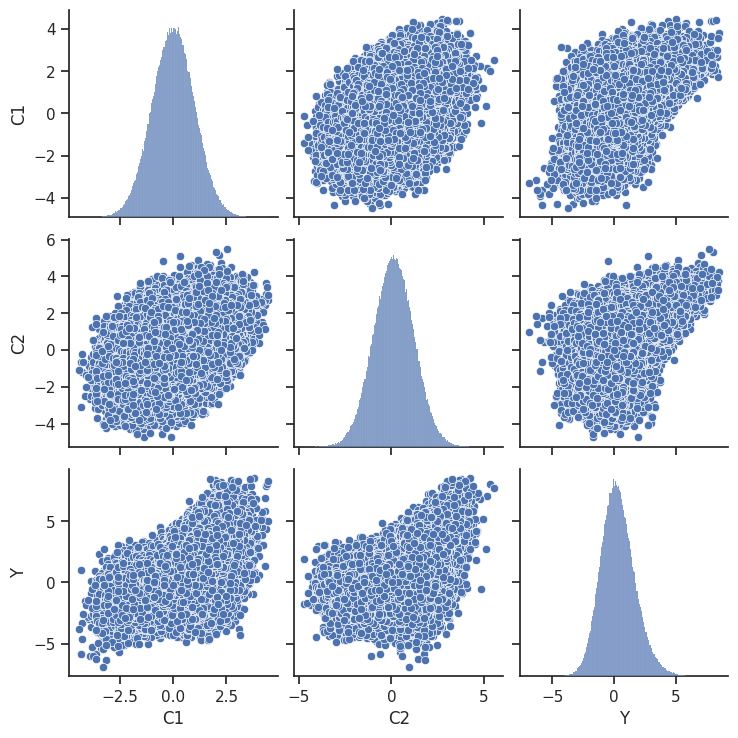

In [6]:
dataset="s3"
data = load_data(dataset, seed=31415)

df_ds1 = data.df_ds1

df_ds1.describe()

df_ds1.head()

df_ds1.describe()

sns.pairplot(df_ds1)

In [ ]:
n_samples = n_mce_samples = data.df.x.shape[0]
dataset_df = df_ds1
batch_size = 1000

n_batches = (n_samples//batch_size)+1
dim = data.df.x.shape[1]

l_do_cat_dims = list(data.cat_dims.keys())
l_do_n_cats = list(data.cat_dims.values())

with torch.no_grad():
#     Z = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
#     z = Z.sample(sample_shape=torch.Size([n_samples])).to(device)
    z_df = torch.zeros(torch.Size([n_samples, dim])).to(device)

    model.eval()

    samples_np = 0

    # perform Abduction step to get the noises Z !!!
    for i, cur_x in enumerate(tqdm(batch_iter(data.df.x, shuffle=False, batch_size=batch_size), total=n_batches)):
        cur_x = cur_x.to(device)
        z, jac = model(cur_x)
        z_df[i*batch_size:i*batch_size+cur_x.shape[0]] = z
    z_df
#     z_df[:,0] = torch.zeros(torch.Size([n_samples]))

    # perform Action step to get the counterfactual quantities for the observational samples using Z
    l_do_cat_dims = list([2,3]) # do(A1,A2)
    l_do_n_cats = list([2,2]) # 2 categories for do A1 and 2 categories for do A2

    if len(l_do_cat_dims) > 1:
        all_a = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats])#.to(device)
    else:
        all_a = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats]).unsqueeze(-1)#.to(device)

    z_do_n = z_df.unsqueeze(1).expand(-1, all_a.shape[0], -1).clone()#.to(device)
    all_a_n=all_a.unsqueeze(0).expand(n_samples,-1,-1).to(device)

    z_do_n[:,:,l_do_cat_dims] = all_a_n
    z_do_U = z_do_n.transpose_(1,0).reshape(-1,dim).to(device)
    cur_x_do_U_inv = torch.zeros_like(z_do_U)

    # perform Prediction step using Z and the interventional/multilated SCM/cGNF model.
    cur_x_do_U_inv = model.invert(z_do_U, do_idx=l_do_cat_dims, do_val=torch.narrow(z_do_U,1,min(l_do_cat_dims),len(l_do_cat_dims)))
#     cur_x_do_U_inv = model.invert(z_do_U)#, do_idx=list([4,5]), do_val=torch.narrow(z_do_U,1,4,2))
    cur_x_do_U_inv = cur_x_do_U_inv.view(-1,n_mce_samples,dim)# treatment-wise grouping


100%|█████████▉| 500/501 [00:12<00:00, 40.52it/s]


In [ ]:
cur_x_do_U_n_inv_mean=cur_x_do_U_inv.mean(1).cpu()#.numpy()
print(f'# ++ Average Counterfactual Outcome = \n{cur_x_do_U_n_inv_mean}')

print('Lambda_10 = '+f'{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]}')
print('Lambda_01 = '+f'{cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]}')
print('Lambda_11 = '+f'{cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]}')

print('Lambdas [10, 01, 11] = '+ f'[{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]:0.3f}]')

# # Open a file with access mode 'a'
# with open(path + "/_cGNF_ATE_lambda.txt", "a") as file_object:
#     file_object.write(f'# {len(d_trn)} ++ cGNF - lambda_[10, 01, 11] =  ,  '+ f'[{cur_x_do_U_n_inv_mean[2,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[1,-1]-cur_x_do_U_n_inv_mean[0,-1]:0.3f}, {cur_x_do_U_n_inv_mean[3,-1]-cur_x_do_U_n_inv_mean[2,-1]:0.3f}]\n')


In [ ]:
cur_x_do_U_inv.shape

In [ ]:
import pandas as pd

# Creating an empty Dataframe with column names only
df_ds1_do_all = []#pd.DataFrame(columns=['C1', 'C2', 'do(A1)', 'do(A2)', 'Y'])

# reorder_vars = ['C1', 'C2', 'do(A1)', 'do(A2)', 'Y']
# df_ds1_do_all = df_ds1_do_all[reorder_vars]
# df_ds1_do_all

l_do_a1_a2 = ['0, 0', '0, 1', '1, 0', '1, 1']

# import matplotlib.pyplot as plt
# #                             fig, ax = plt.subplots(figsize=(6,6),
# #                                                           dpi=200)
# # fig, (ax, ax1) = plt.subplots(2, 1, figsize=(6, 7), 
# # #                             ,gridspec_kw={'width_ratios': [1,1]},
# #                     gridspec_kw={'height_ratios': [1,1.5]},
# #                       dpi=200)

# fig = plt.figure(figsize=(6,6), dpi=200)
# ax = plt.gca()#.get_legend_handles_labels()


for i, this_do_a1_a2 in enumerate(l_do_a1_a2):
    
    df_ds1_do = pd.DataFrame(cur_x_do_U_inv[i,:,:].cpu().numpy(),
#         columns=[r'$C_1$', r'$C_2$', r'do($A_1$)', r'do($A_2$)', r'$Y$'])
        columns=['C1', 'C2', 'A1', 'A2', 'Y'])

    reorder_vars = ['C1', 'C2', 'A1', 'A2', 'Y']
    df_ds1_do = df_ds1_do[reorder_vars]
#     df_ds1_do
    
#     g = sns.kdeplot(df_ds1_do['Y'],ax=ax, label=this_do_a1_a2)
    
#     df_ds1_do[r'do($A_1$), do($A_2$)'] = pd.Series([this_do_a1_a2]*df_ds1_do.shape[0])
    df_ds1_do['do(A1), do(A2)'] = pd.Series([this_do_a1_a2]*df_ds1_do.shape[0])
    
    df_ds1_do_all.append(df_ds1_do)
    
df_ds1_do_all = pd.concat(df_ds1_do_all)#.reset_index()
df_ds1_do_all = df_ds1_do_all#[[r'$C_1$', r'$C_2$', r'do($A_1$)', r'do($A_2$)', r'$Y$', r'do($A_1$), do($A_2$)']]
df_ds1_do_all = df_ds1_do_all#.set_index([r'do($A_1$), do($A_2$)'])
df_ds1_do_all   


# g = sns.kdeplot(df_ds1_do_all, x=r'$Y$', hue=r'do($A_1$), do($A_2$)')
# g = sns.kdeplot(df_ds1_do_all, x='Y', hue='do(A1), do(A2)')
# g.fig.suptitle(f'Interventional densities from the c-GNF', y=1.002)
# plt.tight_layout()

# out_filename = path + f'/Y_interventional_distribution_plot.png'
# g.savefig(f'{out_filename}', dpi=100, bbox_inches="tight")
# #             sns.move_legend(g, "upper left", bbox_to_anchor=(.55, .45), title='Model')
# plt.show()

# import os
# os.system(f'mogrify -trim {out_filename}')


In [ ]:
df_Y_ds1_all = pd.DataFrame(columns=[r'$\hat{Y}_{0,0}$',r'$\hat{Y}_{0,1}$', r'$\hat{Y}_{1,0}$',r'$\hat{Y}_{1,1}$'])
df_Y_ds1_all

df_Y_ds1_all[r'$\hat{Y}_{0,0}$'] = pd.Series(cur_x_do_U_inv[0,:,-1].cpu().numpy())

df_Y_ds1_all[r'$\hat{Y}_{0,1}$'] = pd.Series(cur_x_do_U_inv[1,:,-1].cpu().numpy())

df_Y_ds1_all[r'$\hat{Y}_{1,0}$'] = pd.Series(cur_x_do_U_inv[2,:,-1].cpu().numpy())

df_Y_ds1_all[r'$\hat{Y}_{1,1}$'] = pd.Series(cur_x_do_U_inv[3,:,-1].cpu().numpy())

df_Y_ds1_all

In [ ]:
LOW = -4.5
HIGH = 4.5

npts=100


xside = np.linspace(LOW, HIGH, npts)
yside = np.linspace(LOW, HIGH, npts)
xx, yy = np.meshgrid(xside, yside)
z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

z = torch.Tensor(z)
n_samples=z.shape[0]
z.shape

z_do_1 = torch.cat((z, torch.zeros((n_samples,3))), dim=1)
z_do_1.shape


l_do_cat_dims = list(model.cat_dims.keys())
l_do_n_cats = list(model.cat_dims.values())

# all_a_1 = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_n_cats]).to(device)
if len(l_do_cat_dims) > 1:
    all_a_1 = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats]).to(device)
else:
    all_a_1 = torch.cartesian_prod(*[torch.arange(0, n_cat).float() for n_cat in l_do_n_cats]).unsqueeze(-1).to(device)
z_do_n_1 = z_do_1.unsqueeze(1).expand(-1, all_a_1.shape[0], -1).clone().to(device)
all_a_n_1=all_a_1.unsqueeze(0).expand(n_samples,-1,-1).to(device)

z_do_n_1[:,:,l_do_cat_dims] = all_a_n_1
z_do_n_1 = z_do_n_1.transpose_(1,0).reshape(-1,dim).to(device)#.view(-1,n_samples,dim)
# z_do_n.view(-1,n_samples,dim)

z_do_n_1.shape

cur_x_do_inv_1 = torch.zeros_like(z_do_n_1).to(device)

# # perform counterfactual inference by doing all the treatments for the full population
cur_x_do_inv_1 = model.invert(z_do_n_1, do_idx=l_do_cat_dims, do_val=torch.narrow(z_do_n_1,1,min(l_do_cat_dims),len(l_do_cat_dims)))
cur_x_do_inv_1 = cur_x_do_inv_1.view(-1,n_samples,dim)
cur_x_do_inv_mean_1=cur_x_do_inv_1.mean(1).cpu().numpy()
print(cur_x_do_inv_mean_1.shape)


y_00 = cur_x_do_inv_1[0,:,-1].cpu().numpy().reshape(npts, npts)
y_01 = cur_x_do_inv_1[1,:,-1].cpu().numpy().reshape(npts, npts)
y_10 = cur_x_do_inv_1[2,:,-1].cpu().numpy().reshape(npts, npts)
y_11 = cur_x_do_inv_1[3,:,-1].cpu().numpy().reshape(npts, npts)

with torch.no_grad():
    u_c1 = z_do_1[:,0].unsqueeze(-1)
    u_c2 = z_do_1[:,1].unsqueeze(-1)
    u_a1 = 0
    u_a2 = 0
    u_y = 0

    n_samples = z_do_1.shape[0]

#     u_c1 = c1
    c1 = u_c1

    mu_C2_0 = 0.4*c1+0.2*0
    mu_C2_1 = 0.4*c1+0.2*1
#     u_c2 = c2 - mu_C2
    c2_0 = u_c2 + mu_C2_0
    c2_1 = u_c2 + mu_C2_1

#     theta_11 = theta_21 = gamma_21 = 0
    theta_11 = theta_21 = 0.2#gamma_21 = 0
    gamma_12 = 0.2
    gamma_21 = 0.4

    mu_Y_00 = 0.4*c1+(0.2+theta_11*c1)*0+(0.4+gamma_21*c1)*(c2_0-0.4*c1-0.2*0)+(0.2+theta_21*c1+0.1*0)*0
    mu_Y_01 = 0.4*c1+(0.2+theta_11*c1)*0+(0.4+gamma_21*c1)*(c2_0-0.4*c1-0.2*0)+(0.2+theta_21*c1+0.1*0)*1
    mu_Y_10 = 0.4*c1+(0.2+theta_11*c1)+(0.4+gamma_21*c1)*(c2_1-0.4*c1-0.2)+(0.2+theta_21*c1+0.1)*0
    mu_Y_11 = 0.4*c1+(0.2+theta_11*c1)+(0.4+gamma_21*c1)*(c2_1-0.4*c1-0.2)+(0.2+theta_21*c1+0.1)

    yt_00 = mu_Y_00 + u_y
    yt_01 = mu_Y_01 + u_y
    yt_10 = mu_Y_10 + u_y
    yt_11 = mu_Y_11 + u_y

    

In [ ]:
df_Y_po_all = pd.DataFrame(columns=[r'$Y_{0,0}$',r'$\hat{Y}_{0,0}$',r'$Y_{0,1}$',r'$\hat{Y}_{0,1}$', r'$Y_{1,0}$',r'$\hat{Y}_{1,0}$',r'$Y_{1,1}$',r'$\hat{Y}_{1,1}$'])
df_Y_po_all

df_Y_po_all[r'$Y_{0,0}$'] = pd.Series(yt_00.reshape(npts* npts))
df_Y_po_all[r'$\hat{Y}_{0,0}$'] = pd.Series(y_00.reshape(npts* npts))

df_Y_po_all[r'$Y_{0,1}$'] = pd.Series(yt_01.reshape(npts* npts))
df_Y_po_all[r'$\hat{Y}_{0,1}$'] = pd.Series(y_01.reshape(npts* npts))

df_Y_po_all[r'$Y_{1,0}$'] = pd.Series(yt_10.reshape(npts* npts))
df_Y_po_all[r'$\hat{Y}_{1,0}$'] = pd.Series(y_10.reshape(npts* npts))

df_Y_po_all[r'$Y_{1,1}$'] = pd.Series(yt_11.reshape(npts* npts))
df_Y_po_all[r'$\hat{Y}_{1,1}$'] = pd.Series(y_11.reshape(npts* npts))

df_Y_po_all

In [ ]:

import matplotlib
# %matplotlib notebook
%matplotlib inline  
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

from mpl_toolkits.mplot3d.axes3d import get_test_data


# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(9,9))

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)


#===============
#  First subplot
#===============
# set up the axes for the first plot
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

surf1 = ax1.plot_surface(xx, yy, y_00, rstride=1, cstride=1, cmap=plt.get_cmap('Greens'),
                       label='Predicted', linewidth=0, antialiased=False)#,
surf1 = ax1.plot_surface(xx, yy, yt_00.cpu().numpy().reshape(npts, npts), rstride=1, cstride=1, cmap=plt.get_cmap('Reds'),
                       label='True', linewidth=0, antialiased=False)#,
ax1.set_xlabel(r'$Z_{C_1}$')
ax1.set_ylabel(r'$Z_{C_2}$')
ax1.set_zlabel(r'$Y_{0,0}$')

# set up the axes for the first plot
ax2 = fig.add_subplot(2, 2, 2, projection='3d')

surf2 = ax2.plot_surface(xx, yy, y_01, rstride=1, cstride=1, cmap=plt.get_cmap('Greens'),
                       label='Predicted', linewidth=0, antialiased=False)#,
surf2 = ax2.plot_surface(xx, yy, yt_01.cpu().numpy().reshape(npts, npts), rstride=1, cstride=1, cmap=plt.get_cmap('Reds'),
                       label='True', linewidth=0, antialiased=False)#,
ax2.set_xlabel(r'$Z_{C_1}$')
ax2.set_ylabel(r'$Z_{C_2}$')
ax2.set_zlabel(r'$Y_{0,1}$')

# set up the axes for the first plot
ax3 = fig.add_subplot(2, 2, 3, projection='3d')

surf3 = ax3.plot_surface(xx, yy, y_10, rstride=1, cstride=1, cmap=plt.get_cmap('Greens'),
                       label='Predicted', linewidth=0, antialiased=False)#,
surf3 = ax3.plot_surface(xx, yy, yt_10.cpu().numpy().reshape(npts, npts), rstride=1, cstride=1, cmap=plt.get_cmap('Reds'),
                       label='True', linewidth=0, antialiased=False)#,
ax3.set_xlabel(r'$Z_{C_1}$')
ax3.set_ylabel(r'$Z_{C_2}$')
ax3.set_zlabel(r'$Y_{1,0}$')

# set up the axes for the first plot
ax4 = fig.add_subplot(2, 2, 4, projection='3d')

surf4 = ax4.plot_surface(xx, yy, y_11, rstride=1, cstride=1, cmap=plt.get_cmap('Greens'),
                       label='Predicted', linewidth=0, antialiased=False)#,
surf4 = ax4.plot_surface(xx, yy, yt_11.cpu().numpy().reshape(npts, npts), rstride=1, cstride=1, cmap=plt.get_cmap('Reds'),
                       label='True', linewidth=0, antialiased=False)#,
ax4.set_xlabel(r'$Z_{C_1}$')
ax4.set_ylabel(r'$Z_{C_2}$')
ax4.set_zlabel(r'$Y_{1,1}$')

# plt.tight_layout(pad=5.0,w_pad=5.0,h_pad=5.0)
plt.tight_layout(#pad=2.0,
                 w_pad=2.0,
#     h_pad=3.0
)
# plt.tight_layout()

fig.savefig(path+'/potential_outcomes_map.png'
            , dpi=100
           )


plt.show()

import os
os.system(f'mogrify -trim {path}/potential_outcomes_map.png')




# cGNF Code ends here !!!